# Detecting Outliers with Cleanlab and PyTorch Image Models (timm)

This 5-minute quickstart tutorial shows how to detect potential outliers in image classification data using Cleanlab and PyTorch. The dataset used is `cifar10` which contains 60,000 images. Each image belongs to 1 of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

**Overview of what we'll do in this tutorial:**

- Load the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and do some basic data pre-processing.
- Create `trainset` and `testset` such that `testset` contains extra categories
- Load pretrained model and extract feature embeddings of `trainset` and `testset`
- Compute outlier scores for each example using cleanlab's `get_outlier_scores` method and analyze results.

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install torch
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions we used: matplotlib==3.5.1, numpy==1.21.6, torch==1.11.0, scikit-learn==1.0.2, torchvision==0.12.0, timm==0.5.4, cleanlab==2.0.0

dependencies = ['builtins','torch','torchvision','torchvision.transforms','numpy','matplotlib.pyplot','warnings','cleanlab','timm']

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

Lets first import the required packages and set some seeds for reproducibility

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings

import cleanlab
from cleanlab.rank import get_outlier_scores
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import NearestNeighbors # import KNN estimator
import timm # resnet50 pre-trained model

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Fetch and scale the Cifar10 dataset

Import `cifar10` dataset. After some basic preprocessing, we manually remove some categories from the training data thereby making them outliers in the test set. For this example we've chosen to remove all categories that are not an animal `[airplane, automobile, ship, truck]` from the training set `trainX`.

In [3]:
# Select how to load the cifar10 data. Load into tensors for training and normalize range 0-1
transform_normalize = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Load cifar10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_normalize)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_normalize)

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
trainy = trainset.targets # get labels
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainset  = torch.utils.data.Subset(trainset, animal_idxs) # select only animals for the train set

# Check the shapes of our training and test sets
print('Trainset length: %s' % (len(trainset)))
print('Testset length: %s' % (len(testset)))

Files already downloaded and verified
Files already downloaded and verified
Trainset length: 30000
Testset length: 10000


#### Lets visualize some of the training and test examples

In [4]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        # define subplot
        X,y = dataset[i]
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_labels[int(y)])
        # plot raw pixel data
        ax.imshow(imshow(X))
    # show the figure
    plt.show()

Observe how there are only animals left in the training set `trainset` below.

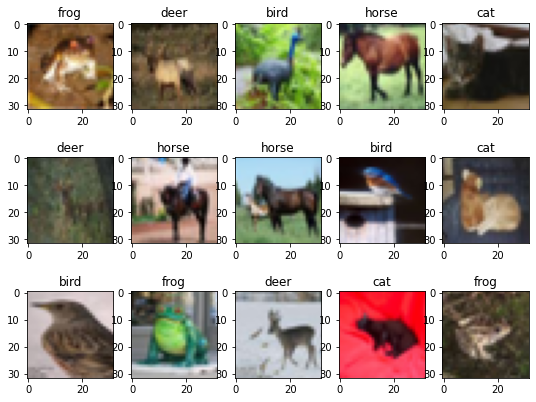

In [5]:
plot_images(trainset)

The test set on the other hand still visibily contains the non-animal images: `[ship, airplane, automobile, truck]`. If we consider `trainset` to be the representative of the normal data distribution then these non-animal images in test dataset `testset` become outliers.

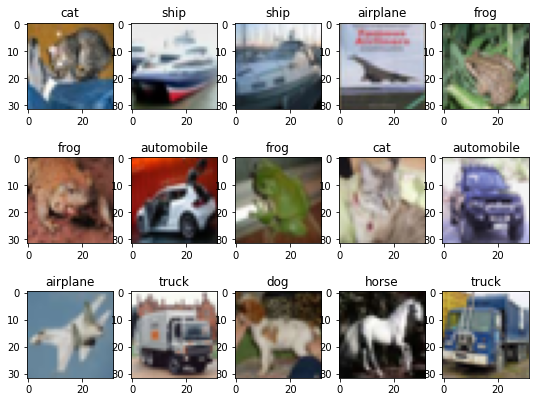

In [6]:
plot_images(testset)

## 3. Import a model and embeddings
The model we are importing comes from [timm](https://timm.fast.ai/), a deep-learning library collection of SOTA models and utilities. We pass in the images into the model to generate embeddings in the feature space used in outlier detection.

The model itself is a `resnet50` but outlier detection can be done with any object capable of generating feature embeddings.

In [7]:
# Download the model from timm
model = timm.create_model('resnet50', pretrained=True, num_classes=0)

# Create dataloaders for more efficient data input into model
batch_size = 15
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
# This cell can take ~1-2 mins
train_feature_embeddings = []

for data in trainloader:
    images, labels = data
    feature_embeddings = model(images)
    train_feature_embeddings.extend(feature_embeddings.detach().numpy())
train_feature_embeddings = np.array(train_feature_embeddings)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')

Train embeddings pooled shape: (30000, 2048)


In [9]:
# This cell can take ~1-2 mins
test_feature_embeddings = []

for data in testloader:
    images, labels = data
    feature_embeddings = model(images)
    test_feature_embeddings.extend(feature_embeddings.detach().numpy())
test_feature_embeddings = np.array(test_feature_embeddings)
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

Test embeddings pooled shape: (10000, 2048)


## 4. Use cleanlab to find outliers in the dataset
With just the feature embeddings, we can use the `cleanlab` library to try and find the artificially added outlier examples `[airplanes, automobiles, trucks, boats]` in the test dataset. We can also check the training data to find any naturally occuring outlier examples.

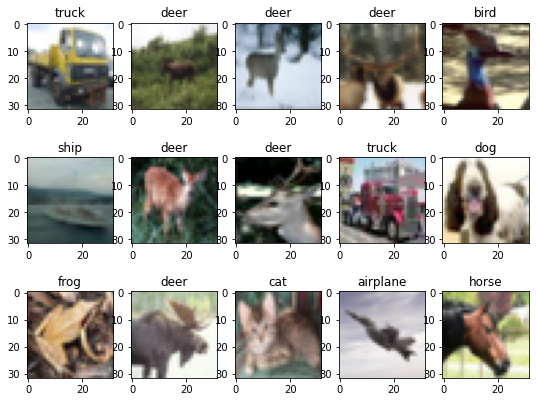

In [10]:
# import KNN estimator and fit it on the resnet50 feature embeddings
knn = NearestNeighbors(n_neighbors=15).fit(train_feature_embeddings)

# get outlier scores for the test feature embeddings
outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn, k=15)

# visualize top 15 outlier scores
top_outlier_idxs = (outlier_scores).argsort()[:15]
top_outlier_subset = torch.utils.data.Subset(testset, top_outlier_idxs)
plot_images(top_outlier_subset)

Notice how majority of the outliers in `testset` belong to the holdout classes `[airplane, automobile, ship]`. These feature representations are futher away in the model representation space than the feature representations of animal images also found in `trainset`.

Just for fun, lets visualize what the `NearestNeighbors` algorithm considers the 15 least probable outliers in our test set. Notice there are a lot less images from the out of distribution classes here.

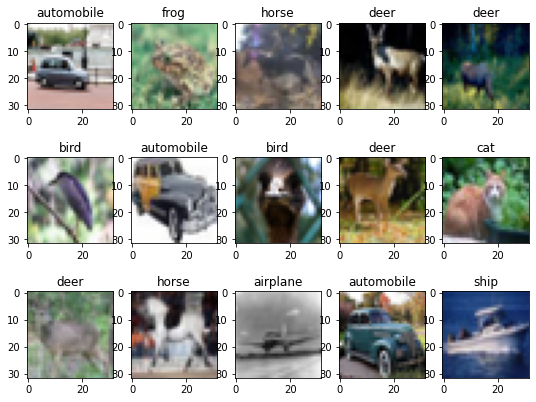

In [11]:
# visualize least probable 15 outlier scores
bottom_outlier_idxs = (-outlier_scores).argsort()[:15]
bottom_outlier_subset = torch.utils.data.Subset(testset, bottom_outlier_idxs)
plot_images(bottom_outlier_subset)

We can also compute the precision/recall of our algorithm for the examples.

In [12]:
animal_labels = [2,3,4,5,6,7] # identify animal labels in the testing dataset
animal_idxs = np.where(np.isin(testset.targets, animal_labels))[0] # find idx of animals
not_outlier = np.zeros(len(testset.targets), dtype=bool) # is outlier
not_outlier[animal_idxs] = True
precision, recall, thresholds = precision_recall_curve(not_outlier, 1 - outlier_scores)

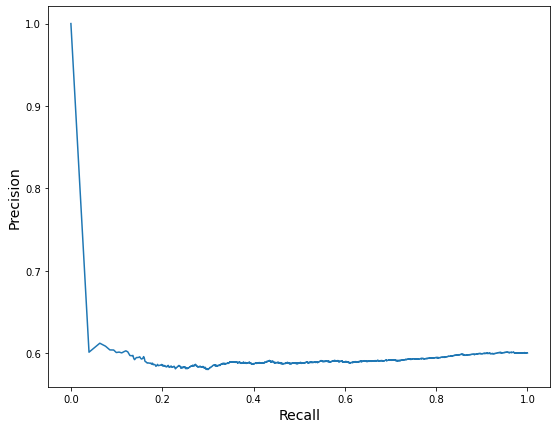

In [13]:
plt.plot(recall, precision)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

### Finding naturally occuring outlier examples

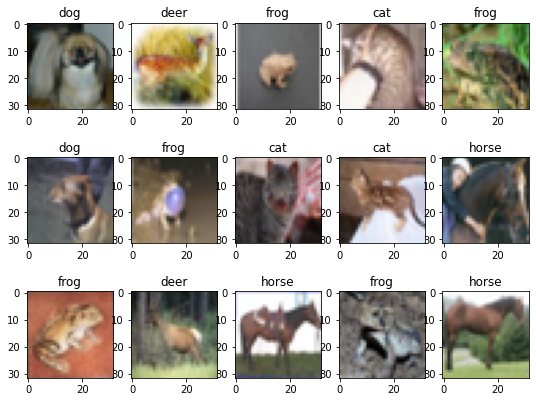

In [14]:
# get outlier scores for our train feature embeddings
outlier_scores = get_outlier_scores(features=train_feature_embeddings, k=15)

# visualize top 15 outlier scores
top_train_outlier_idxs = (outlier_scores).argsort()[:15]
top_train_outlier_subset = torch.utils.data.Subset(trainset, top_train_outlier_idxs)
plot_images(top_train_outlier_subset)

Just for fun, lets see what our model considers the least likeley outliers in the training set! These examples are very homogeneous.

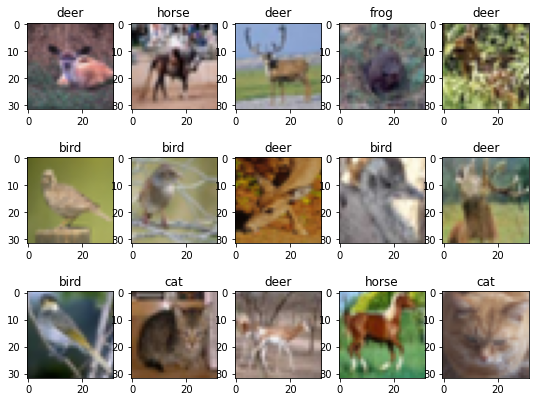

In [15]:
# visualize bottom 15 outlier scores on train set
bottom_train_outlier_idxs = (-outlier_scores).argsort()[:15]
bottom_train_outlier_subset = torch.utils.data.Subset(trainset, bottom_train_outlier_idxs)
plot_images(bottom_train_outlier_subset)

In [16]:
# # Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# top_outlier_idxs_test = [ 1280, 13254,  6725, 13708, 11397, 11276,  4115,  6938, 14509, 9438,  9832,  3589, 12862,  8287,  4846]
# bottom_outlier_idxs_test =[6165, 5020, 8466, 4322, 1914, 5113, 6697, 7608,  273, 7802, 7795,4325, 6125,  910, 8448]

# if not all(x in top_outlier_idxs for x in top_outlier_idxs_test):
#     raise Exception("Some highlighted examples are missing from top outliers in test set.")

# if not all(x in bottom_outlier_idxs for x in bottom_outlier_idxs_test):
#     raise Exception("Some highlighted examples are missing from bottom test set outliers.")